In [1]:
!pip install h2o

     |████████████████████████████████| 168.4 MB 61 kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.6-py2.py3-none-any.whl size=168439194 sha256=8ef45c4b5a1709670eb755c2489e56ab77eccd8d57b0a1055b678c6dcab03b0b
  Stored in directory: /root/.cache/pip/wheels/ee/0f/51/849ba221c4c1b11a04efb4a3427dc9cb1c4dcde218c6c98b13
Successfully built h2o


In [2]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import statsmodels.api as sm
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import time, warnings, h2o, logging, os, sys, psutil, random
from h2o.automl import H2OAutoML
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OXGBoostEstimator
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
sns.set_style('whitegrid')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data preprocessing

In [4]:
train_df = pd.read_csv("/content/qt_dataset.csv",encoding='utf-8',index_col=0)
train_df

,Oxy,Pulse,Temp,Result
ID,,,,
0,98,65,95,Negative
1,96,92,95,Negative
2,95,92,99,Negative
3,97,56,96,Negative
4,88,94,98,Positive
...,...,...,...,...
9995,95,124,97,Negative
9996,88,70,100,Positive
9997,99,56,105,Negative


In [5]:
train_df.head()

,Oxy,Pulse,Temp,Result
ID,,,,
0,98,65,95,Negative
1,96,92,95,Negative
2,95,92,99,Negative
3,97,56,96,Negative
4,88,94,98,Positive


In [6]:
train_df.describe()

,Oxy,Pulse,Temp
count,10000.000000,10000.000000,10000.000000
mean,92.548900,84.976600,100.000700
std,4.611197,26.305841,3.185045
min,85.000000,40.000000,95.000000
25%,88.000000,63.000000,97.000000
50%,93.000000,85.000000,100.000000
75%,97.000000,108.000000,103.000000
max,100.000000,130.000000,105.000000


均值差不多，可以考虑归一化，但有PULSE方差过大，需要标准化

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Oxy     10000 non-null  int64 
 1   Pulse   10000 non-null  int64 
 2   Temp    10000 non-null  int64 
 3   Result  10000 non-null  object
dtypes: int64(3), object(1)
memory usage: 390.6+ KB


没有缺失值哦

## label转换为数值型数据

In [8]:
from sklearn import preprocessing

for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(np.unique(list(train_df[f].values)))
        train_df[f] = lbl.transform(list(train_df[f].values))
        # test_df[f] = lbl.transform(list(test_df[f].values))

In [9]:
train_df.isna().any()

Oxy       False
Pulse     False
Temp      False
Result    False
dtype: bool

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Oxy     10000 non-null  int64
 1   Pulse   10000 non-null  int64
 2   Temp    10000 non-null  int64
 3   Result  10000 non-null  int64
dtypes: int64(4)
memory usage: 390.6 KB


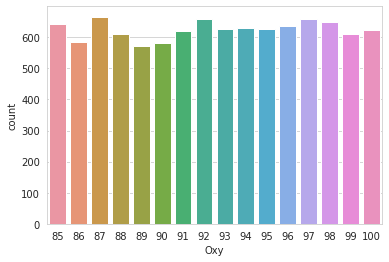

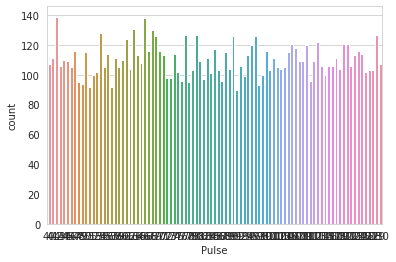

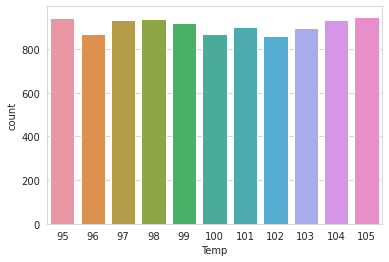

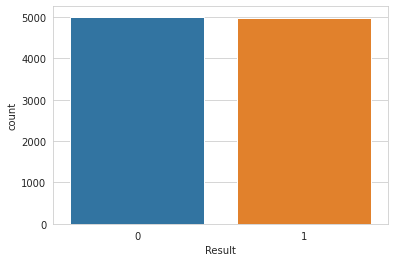

In [11]:
for i in train_df.columns:
  sns.countplot(x=i, data=train_df)
  plt.savefig('%s.jpg'%i)
  plt.show()


Check the specific number of positive and negative samples

In [12]:
train_df['Result'].value_counts()

0    5010
1    4990
Name: Result, dtype: int64

数据为均衡数据

In [13]:
train_df['label']=train_df['Result']


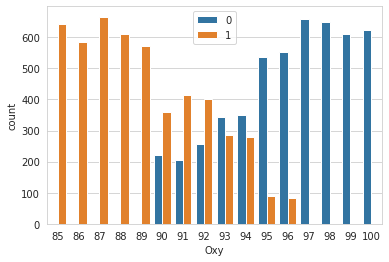

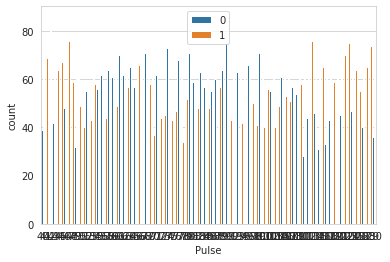

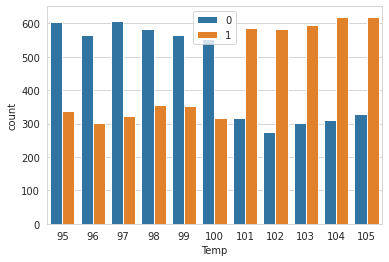

In [14]:

for i in train_df.columns[:3]:
  sns.countplot(x=i,hue="label", data=train_df)
  plt.legend()
  plt.savefig('%s-result.jpg'%i)
  plt.show()

上图有规律可循

In [15]:
y_train = train_df.loc[:,'label']
X_train = train_df.drop(columns=['label','Result'])
print(X_train.shape)
print(X_train.columns)
from sklearn import preprocessing
X_train_scale = pd.DataFrame(preprocessing.scale(X_train))
X_train_scale.columns = X_train.columns
X_train_scale.index = X_train.index


(10000, 3)
Index(['Oxy', 'Pulse', 'Temp'], dtype='object')


In [16]:
X_train

,Oxy,Pulse,Temp
ID,,,
0,98,65,95
1,96,92,95
2,95,92,99
3,97,56,96
4,88,94,98
...,...,...,...
9995,95,124,97
9996,88,70,100
9997,99,56,105


# Calculate correlation

In [17]:
X_train.corr()

,Oxy,Pulse,Temp
Oxy,1.000000,-0.005724,-0.015681
Pulse,-0.005724,1.000000,0.009602
Temp,-0.015681,0.009602,1.000000


Plot Number:  1


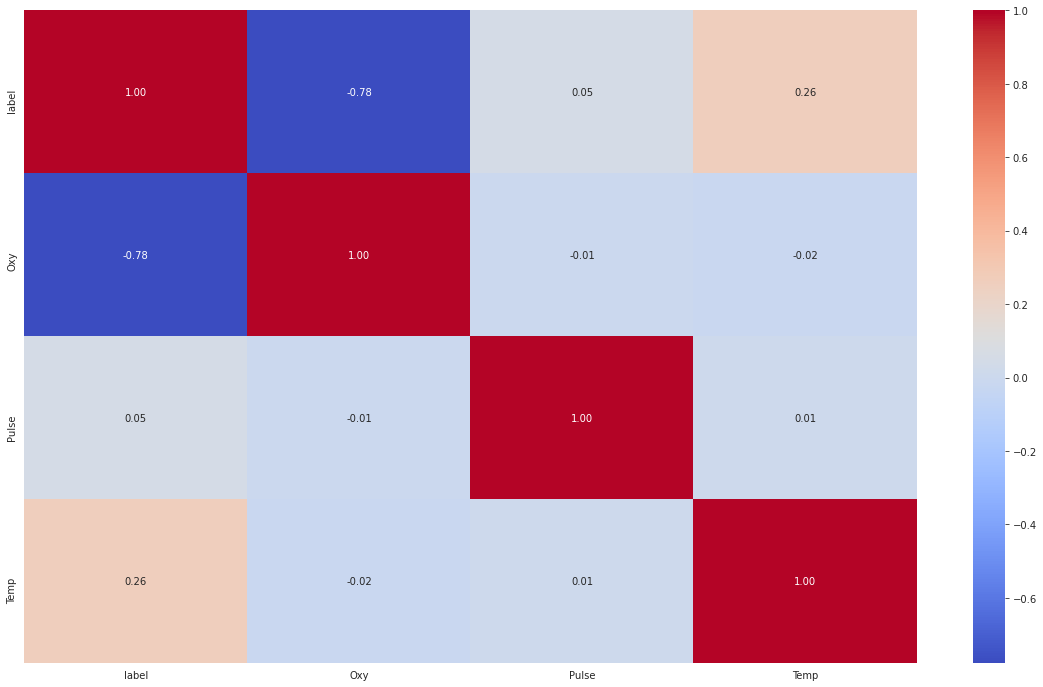

In [18]:
counter=0
plt_cnt=0
for columns in X_train:
    if counter == 0:
        df_heat= pd.DataFrame(train_df["label"])
        plt_cnt=plt_cnt+1
    if counter<3:
        counter=counter+1
        df_heat[columns]= + train_df[columns]
    if counter==3:
        print("Plot Number: " , plt_cnt)
        plt.figure(figsize=(20,12))
        sns.heatmap(data=df_heat.iloc[:,:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
        plt.savefig('1.jpg',dpi=300)
        plt.show()
        
        counter=0
        df_heat=df_heat.iloc[0:0]

# confuse_matrix

In [19]:
# 混淆矩阵
def plot_confuse_matrix(matrix):
  sns.set()
  f,ax=plt.subplots()
  sns.heatmap(matrix,annot=True,fmt='.20g',cmap="Blues",ax=ax)
  ax.set_title('confusion matrix') 
  ax.set_xlabel('predict') 
  ax.set_ylabel('true') 
  plt.savefig('confuse_matrix.jpg')
  plt.show()

# logisticRegression

In [20]:

columns_name = X_train.columns

In [21]:
lr = LogisticRegression(random_state=0)

In [22]:
Xlog_train, Xlog_test, ylog_train, ylog_test = train_test_split(X_train,y_train,test_size=0.2)


In [23]:
print (Xlog_train.shape, ylog_train.shape)
print (Xlog_test.shape, ylog_test.shape)

(8000, 3) (8000,)
(2000, 3) (2000,)


In [24]:
results_logistic = lr.fit(Xlog_train, ylog_train)
print (results_logistic)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [25]:
ylog_pred = lr.predict(Xlog_test)
ylog_pred

array([1, 0, 1, ..., 1, 1, 0])

Person Correlation coefficient, 0.8380899045773657 0.0
Precision 0.919
Recall 0.919
F1-score 0.919
Confusion Matrix
 [[918  74]
 [ 88 920]]
Classification Report
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       992
           1       0.93      0.91      0.92      1008

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


TPR [2 1 0]
FPR [0.    0.497 1.   ]
PPV 0.9255533199195171


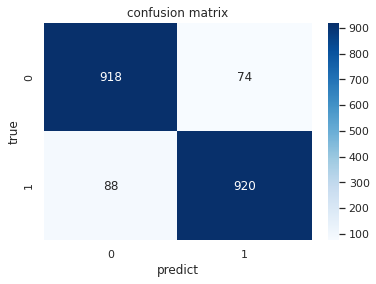

Accuracy: 0.919
Sensitivity: 0.9126984126984127
Specificity: 0.9254032258064516
(2000, 1)


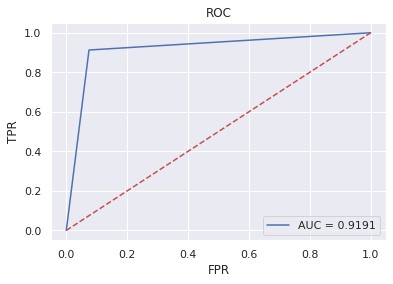

In [26]:
import scipy.stats as stats
from sklearn.metrics import *
r, p = stats.pearsonr(ylog_test, ylog_pred)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, ylog_pred,average='micro'))
print('Recall',recall_score(ylog_test, ylog_pred,average='micro'))
print('F1-score',f1_score(ylog_test, ylog_pred,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, ylog_pred ))
print('Classification Report\n',classification_report(ylog_test, ylog_pred))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, ylog_pred, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, ylog_pred)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)
    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, ylog_pred)
from sklearn.metrics import roc_curve
ylog_pred = ylog_pred.reshape(-1,1)
print(ylog_pred.shape)
from sklearn.metrics import auc

def plot_roc():
    false_positive_rate,true_positive_rate,thresholds=roc_curve(ylog_test, ylog_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.savefig('roc.jpg')
plot_roc()

## 对比标准化和没有标准化的结果

Person Correlation coefficient, 0.8440158654078387 0.0
Precision 0.922
Recall 0.922
F1-score 0.922
Confusion Matrix
 [[940  72]
 [ 84 904]]
Classification Report
               precision    recall  f1-score   support

           0       0.92      0.93      0.92      1012
           1       0.93      0.91      0.92       988

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


TPR [2 1 0]
FPR [0.    0.488 1.   ]
PPV 0.9262295081967213


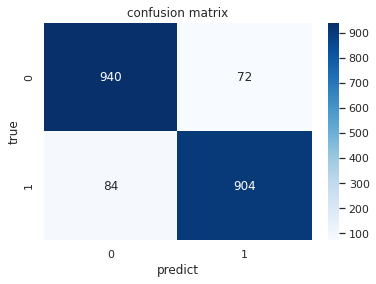

Accuracy: 0.922
Sensitivity: 0.9149797570850202
Specificity: 0.9288537549407114
(2000, 1)


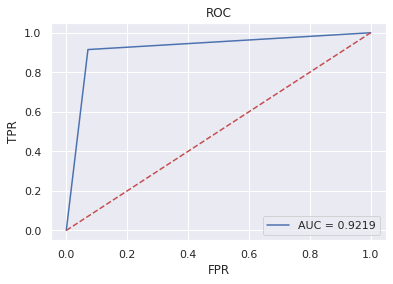

In [27]:
Xlog_train_scale, Xlog_test_scale, ylog_train, ylog_test = train_test_split(X_train_scale,y_train,test_size=0.2)

results_logistic_scale = lr.fit(Xlog_train_scale, ylog_train)
ylog_pred = lr.predict(Xlog_test_scale)
import scipy.stats as stats
from sklearn.metrics import *
r, p = stats.pearsonr(ylog_test, ylog_pred)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, ylog_pred,average='micro'))
print('Recall',recall_score(ylog_test, ylog_pred,average='micro'))
print('F1-score',f1_score(ylog_test, ylog_pred,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, ylog_pred ))
print('Classification Report\n',classification_report(ylog_test, ylog_pred))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, ylog_pred, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, ylog_pred)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)

    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, ylog_pred)
from sklearn.metrics import roc_curve
ylog_pred = ylog_pred.reshape(-1,1)
print(ylog_pred.shape)
from sklearn.metrics import auc


plot_roc()

In [28]:
#上面证明我们标准化是对结果有积极影响 所以我们接下来均使用标准化的数据进行训练测试
Xlog_train = Xlog_train_scale
Xlog_test = Xlog_test_scale

# DT

Person Correlation coefficient, 0.8440158654078387 0.0
Precision 1.0
Recall 1.0
F1-score 1.0
Confusion Matrix
 [[1012    0]
 [   0  988]]
Classification Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1012
           1       1.00      1.00      1.00       988

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


TPR [2 1 0]
FPR [0.    0.494 1.   ]
PPV 1.0


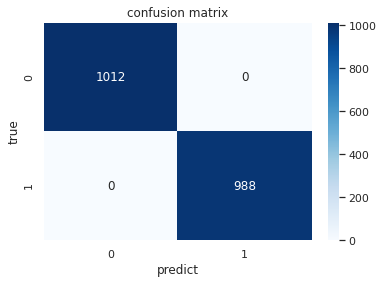

Accuracy: 1.0
Sensitivity: 1.0
Specificity: 1.0
(2000, 1)


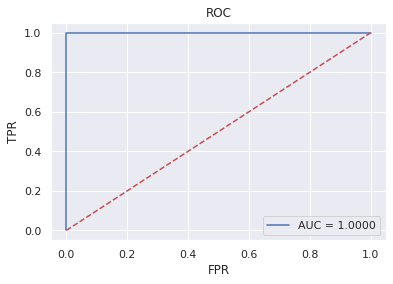

In [29]:

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(Xlog_train, ylog_train)
ylog_pred =clf.predict(Xlog_test)
import scipy.stats as stats
from sklearn.metrics import *
# r, p = stats.pearsonr(ylog_test, ylog_pred)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, ylog_pred,average='micro'))
print('Recall',recall_score(ylog_test, ylog_pred,average='micro'))
print('F1-score',f1_score(ylog_test, ylog_pred,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, ylog_pred ))
# 4、模型报告
print('Classification Report\n',classification_report(ylog_test, ylog_pred))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, ylog_pred, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, ylog_pred)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)

    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, ylog_pred)
from sklearn.metrics import roc_curve
ylog_pred = ylog_pred.reshape(-1,1)
print(ylog_pred.shape)
from sklearn.metrics import auc


plot_roc()

# SVM

Person Correlation coefficient, 0.8440158654078387 0.0
Precision 0.97
Recall 0.97
F1-score 0.97
Confusion Matrix
 [[982  30]
 [ 30 958]]
Classification Report
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1012
           1       0.97      0.97      0.97       988

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


TPR [2 1 0]
FPR [0.    0.494 1.   ]
PPV 0.9696356275303644


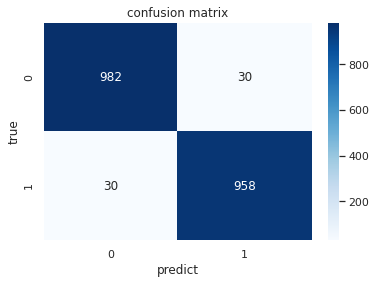

Accuracy: 0.97
Sensitivity: 0.9696356275303644
Specificity: 0.9703557312252964
(2000, 1)


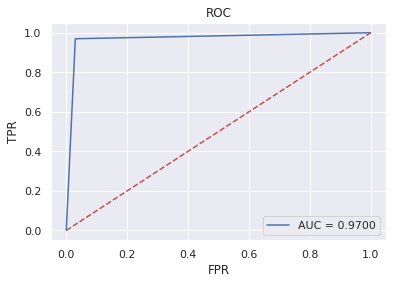

In [30]:
clf = SVC()
clf = clf.fit(Xlog_train, ylog_train)
ylog_pred =clf.predict(Xlog_test)
import scipy.stats as stats
from sklearn.metrics import *
# r, p = stats.pearsonr(ylog_test, ylog_pred)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, ylog_pred,average='micro'))
print('Recall',recall_score(ylog_test, ylog_pred,average='micro'))
print('F1-score',f1_score(ylog_test, ylog_pred,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, ylog_pred ))
# 4、模型报告
print('Classification Report\n',classification_report(ylog_test, ylog_pred))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, ylog_pred, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, ylog_pred)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)

    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, ylog_pred)
from sklearn.metrics import roc_curve
ylog_pred = ylog_pred.reshape(-1,1)
print(ylog_pred.shape)
from sklearn.metrics import auc

plot_roc()

# nb

Person Correlation coefficient, 0.8440158654078387 0.0
Precision 0.8865
Recall 0.8865
F1-score 0.8865
Confusion Matrix
 [[907 105]
 [122 866]]
Classification Report
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      1012
           1       0.89      0.88      0.88       988

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


TPR [2 1 0]
FPR [0.     0.4855 1.    ]
PPV 0.8918640576725025


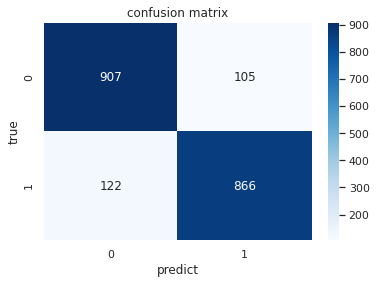

Accuracy: 0.8865
Sensitivity: 0.8765182186234818
Specificity: 0.8962450592885376
(2000, 1)


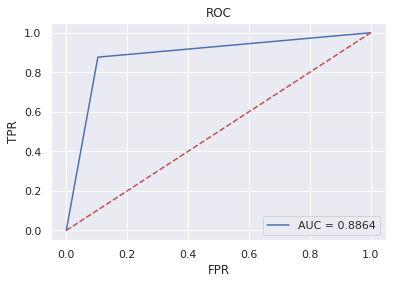

In [31]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf = clf.fit(Xlog_train, ylog_train)
ylog_pred =clf.predict(Xlog_test)
import scipy.stats as stats
from sklearn.metrics import *
# r, p = stats.pearsonr(ylog_test, ylog_pred)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, ylog_pred,average='micro'))
print('Recall',recall_score(ylog_test, ylog_pred,average='micro'))
print('F1-score',f1_score(ylog_test, ylog_pred,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, ylog_pred ))
# 4、模型报告
print('Classification Report\n',classification_report(ylog_test, ylog_pred))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, ylog_pred, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, ylog_pred)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)
    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, ylog_pred)
from sklearn.metrics import roc_curve
ylog_pred = ylog_pred.reshape(-1,1)
print(ylog_pred.shape)
from sklearn.metrics import auc


plot_roc()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


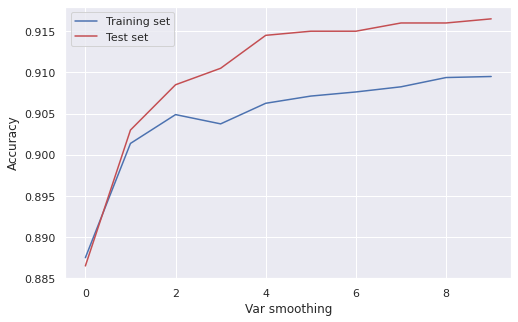

In [38]:
import math
var_smoothing = [i for i in range(10)]
print(var_smoothing)
train_score =[]
test_score =[]
for feat in var_smoothing:
    clf = GaussianNB(var_smoothing=feat)
    clf = clf.fit(Xlog_train, ylog_train)
    ylog_pred =clf.predict(Xlog_test)
    train_score.append(clf.score(Xlog_train,ylog_train))
    test_score.append(clf.score(Xlog_test,ylog_test))

plt.figure(figsize = (8,5))
plt.plot(var_smoothing,train_score,c='b')
plt.plot(var_smoothing, test_score, c='r')
plt.xlabel('Var smoothing')
plt.ylabel('Accuracy')

plt.legend(['Training set','Test set'])
plt.show()

# RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier     #导入需要的模块

rfc = RandomForestClassifier()                      #实例化
rfc = rfc.fit(Xlog_train,ylog_train)
ylog_pred =rfc.predict(Xlog_test)
import scipy.stats as stats
from sklearn.metrics import *
# r, p = stats.pearsonr(ylog_test, ylog_pred)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, ylog_pred,average='micro'))
print('Recall',recall_score(ylog_test, ylog_pred,average='micro'))
print('F1-score',f1_score(ylog_test, ylog_pred,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, ylog_pred ))
# 4、模型报告
print('Classification Report\n',classification_report(ylog_test, ylog_pred))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, ylog_pred, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, ylog_pred)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)

    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, ylog_pred)
from sklearn.metrics import roc_curve
ylog_pred = ylog_pred.reshape(-1,1)
print(ylog_pred.shape)
from sklearn.metrics import auc


plot_roc()

# XGBOOST

In [ ]:
params = {
 'learning_rate' :0.1,
 'n_estimators':1000,
 'max_depth':5,
 'min_child_weight':1,
 'gamma':0,
 'subsample':0.8,
 'colsample_bytree':0.8,
 'objective': 'binary:logistic',
 'nthread':4,
 'scale_pos_weight':1,
 'seed':27
 }
X_train_xgb = xgb.DMatrix(Xlog_train,ylog_train)

X_test_xgb  = xgb.DMatrix(Xlog_test)
# X_xgb  = xgb.DMatrix(X_test.values)

In [ ]:
Xgbm = xgb.train(params, X_train_xgb, 50)

In [ ]:
yxgb_pred = (Xgbm.predict(X_test_xgb)>=0.5*1).astype(int)
# y_xgb = (Xgbm.predict(X_xgb)>=0.5*1).astype(int)
print(yxgb_pred.shape)
print(ylog_test.shape)

In [ ]:
import scipy.stats as stats
from sklearn.metrics import *
r, p = stats.pearsonr(ylog_test, yxgb_pred)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, yxgb_pred,average='micro'))
print('Recall',recall_score(ylog_test, yxgb_pred,average='micro'))
print('F1-score',f1_score(ylog_test, yxgb_pred,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, yxgb_pred ))
# 4、模型报告
print('Classification Report\n',classification_report(ylog_test, yxgb_pred))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, yxgb_pred, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, yxgb_pred)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)

    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, yxgb_pred)
from sklearn.metrics import roc_curve
yxgb_pred = yxgb_pred.reshape(-1,1)
print(yxgb_pred.shape)
from sklearn.metrics import auc


plot_roc()

In [ ]:
feat_imp = pd.Series(Xgbm.get_score(importance_type="gain")).sort_values(ascending=False)[:10]
print(feat_imp.index)
print(feat_imp)
print(columns_name)
# listr=[]
# for i in feat_imp.index:
#   listr.append(columns_name[int(str(i).split('f')[1])])
# feat_imp.index= listr
feat_imp.plot(kind='bar', title='Feature Importances',figsize=(20,12))
plt.ylabel('Feature Importance Score')
plt.savefig('2.jpg',dpi=300)

In [ ]:
# print(y_xgb)

# Lightgbm

In [ ]:
params = {
'task': 'train',
'boosting_type': 'gbdt',  
'objective': 'binary', 
'metric': {'5', 'auc'},  
'num_leaves': 31,  
'learning_rate': 0.05,  
'feature_fraction': 0.9,  
'bagging_fraction': 0.8,  
'bagging_freq': 50,  
'verbose': 1  
}
X_train_lgb = lgb.Dataset(Xlog_train,ylog_train)

X_test_lgb  = lgb.Dataset(Xlog_test,ylog_test,reference=X_train_lgb)
# X_lgb  = lgb.Dataset(X_test.values)

In [ ]:
gbm = lgb.train(params, X_train_lgb, num_boost_round=20, valid_sets=X_test_lgb, early_stopping_rounds=5)


[1]	valid_0's auc: 0.989193
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's auc: 0.996783
[3]	valid_0's auc: 0.994756
[4]	valid_0's auc: 0.997029
[5]	valid_0's auc: 0.997169
[6]	valid_0's auc: 0.998867
[7]	valid_0's auc: 0.998475
[8]	valid_0's auc: 0.998606
[9]	valid_0's auc: 0.998646
[10]	valid_0's auc: 0.999374
[11]	valid_0's auc: 0.999653
[12]	valid_0's auc: 0.999817
[13]	valid_0's auc: 0.999909
[14]	valid_0's auc: 0.999887
[15]	valid_0's auc: 0.999931
[16]	valid_0's auc: 0.999902
[17]	valid_0's auc: 0.999911
[18]	valid_0's auc: 0.999882
[19]	valid_0's auc: 0.999849
[20]	valid_0's auc: 0.999819
Early stopping, best iteration is:
[15]	valid_0's auc: 0.999931


In [ ]:
y_pred_lgb = (gbm.predict(Xlog_test, num_iteration=gbm.best_iteration)>=0.5*1).astype('int')
y_pred_lgb

array([1, 0, 0, ..., 0, 1, 0])

Person Correlation coefficient, 0.9781929567439367 0.0
Precision 0.989
Recall 0.989
F1-score 0.989
Confusion Matrix
 [[ 974    1]
 [  21 1004]]
Classification Report
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       975
           1       1.00      0.98      0.99      1025

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


TPR [2 1 0]
FPR [0.     0.5025 1.    ]
PPV 0.9990049751243781


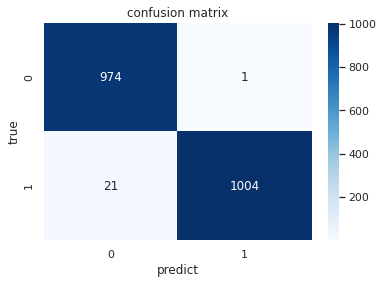

Accuracy: 0.989
Sensitivity: 0.9795121951219512
Specificity: 0.9989743589743589
(2000, 1)


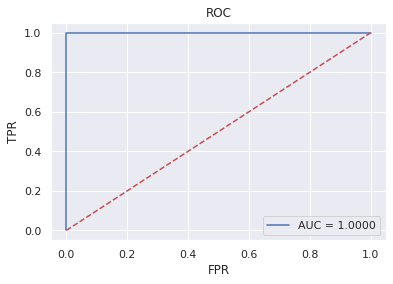

In [ ]:
import scipy.stats as stats
from sklearn.metrics import *
r, p = stats.pearsonr(ylog_test, y_pred_lgb)
print('Person Correlation coefficient,', r, p)
print('Precision',precision_score(ylog_test, y_pred_lgb,average='micro'))
print('Recall',recall_score(ylog_test, y_pred_lgb,average='micro'))
print('F1-score',f1_score(ylog_test, y_pred_lgb,average='micro'))
print('Confusion Matrix\n',confusion_matrix(ylog_test, y_pred_lgb ))
# 4、模型报告
print('Classification Report\n',classification_report(ylog_test, y_pred_lgb))
fpr, tpr, thresholds = metrics.roc_curve(ylog_test, y_pred_lgb, pos_label=2)
print('TPR',thresholds)
print('FPR',fpr)
PPv = precision_score(ylog_test, y_pred_lgb)
print('PPV',PPv)
def calculate_metric(gt, pred):
    pred[pred>0.5]=1
    pred[pred<1]=0
    confusion = confusion_matrix(gt,pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    plot_confuse_matrix(confusion)

    print('Accuracy:',(TP+TN)/float(TP+TN+FP+FN))
    print('Sensitivity:',TP / float(TP+FN))
    print('Specificity:',TN / float(TN+FP))
calculate_metric(ylog_test, y_pred_lgb)
from sklearn.metrics import roc_curve
y_pred_lgb = y_pred_lgb.reshape(-1,1)
print(y_pred_lgb.shape)
from sklearn.metrics import auc

plot_roc()
plt.savefig('roc.jpg')

# H2O

In [ ]:
pct_memory=0.95
virtual_memory=psutil.virtual_memory()
print("Virtual Memory Size: ",virtual_memory)
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print("Minimum Memory Size: ",min_mem_size)

Virtual Memory Size:  svmem(total=13622198272, available=3815493632, percent=72.0, used=9916657664, free=162099200, active=10201780224, inactive=2923479040, buffers=138014720, cached=3405426688, shared=1179648, slab=255275008)
Minimum Memory Size:  3


In [ ]:
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:11070 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzy_59wql
  JVM stdout: /tmp/tmpzy_59wql/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzy_59wql/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:11070
Connecting to H2O server at http://127.0.0.1:11070 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.6
H2O_cluster_version_age:,19 hours and 14 minutes
H2O_cluster_name:,H2O_from_python_unknownUser_r3qkhu
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [ ]:
H2O_train = h2o.import_file("/content/qt_dataset.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:

Target='Result'

In [ ]:
H2O_train[Target] = H2O_train[Target].asfactor()


In [ ]:
aml = H2OAutoML(max_runtime_secs=600, seed=27)


In [ ]:

model_start_time = time.time()
aml.train(x=predictors, y=Target, training_frame=H2O_train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [ ]:
meta_data={}
meta_data['model_execution_time'] = {"classification":(time.time() - model_start_time)}
meta_data

{'model_execution_time': {'classification': 608.7723994255066}}

In [ ]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20210820_140425_model_1,1,0.000914953,1,0,0.00263973,6.96815e-06
XGBoost_grid__1_AutoML_20210820_140425_model_4,1,0.0073341,1,0,0.0151612,0.000229861
GBM_1_AutoML_20210820_140425,1,0.00188554,1,0,0.00769056,5.91448e-05
DRF_1_AutoML_20210820_140425,1,0.00491194,1,0,0.0228934,0.000524109
GBM_grid__1_AutoML_20210820_140425_model_1,1,0.00547284,1,0,0.0190203,0.000361771
XGBoost_3_AutoML_20210820_140425,1,0.00247014,1,0,0.00719023,5.16994e-05
StackedEnsemble_BestOfFamily_AutoML_20210820_140425,1,0.0026623,1,0,0.0100444,0.000100891
XGBoost_grid__1_AutoML_20210820_140425_model_5,1,0.0484633,1,0,0.0742805,0.0055176
GBM_grid__1_AutoML_20210820_140425_model_2,1,0.0495025,1,0,0.077709,0.00603868
GBM_2_AutoML_20210820_140425,1,0.000624808,1,0,0.00579008,3.3525e-05


In [ ]:
aml_leaderboard_df=aml.leaderboard.as_data_frame()
model_set=aml_leaderboard_df['model_id']
mod_best1=h2o.get_model(model_set[0])

In [ ]:
print(mod_best1.auc())

1.0


In [ ]:
print(mod_best1.algo)

xgboost


In [ ]:
# pred_H2O=mod_best1.predict(H2O_test)

In [ ]:
# pred_H2O

In [ ]:
print(mod_best1.model_id)

XGBoost_grid__1_AutoML_20210820_140425_model_1


In [ ]:
print(mod_best1.gini)

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20210820_140425_model_1


Model Summary: 


,,number_of_trees
0,,454.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 3.3021410709897498e-06
RMSE: 0.0018171794272965314
LogLoss: 0.0006871869794054748
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9630945920944214: 


,,Negative,Positive,Error,Rate
0,Negative,5010.0,0.0,0.0,(0.0/5010.0)
1,Positive,0.0,4990.0,0.0,(0.0/4990.0)
2,Total,5010.0,4990.0,0.0,(0.0/10000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,9.630946e-01,1.000000,212.0
1,max f2,9.630946e-01,1.000000,212.0
2,max f0point5,9.630946e-01,1.000000,212.0
3,max accuracy,9.630946e-01,1.000000,212.0
4,max precision,9.999993e-01,1.000000,0.0
5,max recall,9.630946e-01,1.000000,212.0
6,max specificity,9.999993e-01,1.000000,0.0
7,max absolute_mcc,9.630946e-01,1.000000,212.0
8,max min_per_class_accuracy,9.630946e-01,1.000000,212.0
9,max mean_per_class_accuracy,9.630946e-01,1.000000,212.0



Gains/Lift Table: Avg response rate: 49.90 %, avg score: 49.90 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.0260,9.999995e-01,2.004008,2.004008,1.00,9.999995e-01,1.000000,1.000000,0.052104,0.052104,100.400802,100.400802,0.052104
1,2,0.0477,9.999994e-01,2.004008,2.004008,1.00,9.999994e-01,1.000000,0.999999,0.043487,0.095591,100.400802,100.400802,0.095591
2,3,0.0520,9.999993e-01,2.004008,2.004008,1.00,9.999993e-01,1.000000,0.999999,0.008617,0.104208,100.400802,100.400802,0.104208
3,4,0.1049,9.999949e-01,2.004008,2.004008,1.00,9.999970e-01,1.000000,0.999998,0.106012,0.210220,100.400802,100.400802,0.210220
4,5,0.1524,9.999942e-01,2.004008,2.004008,1.00,9.999945e-01,1.000000,0.999997,0.095190,0.305411,100.400802,100.400802,0.305411
5,6,0.2008,9.999816e-01,2.004008,2.004008,1.00,9.999877e-01,1.000000,0.999995,0.096994,0.402405,100.400802,100.400802,0.402405
6,7,0.3000,9.997314e-01,2.004008,2.004008,1.00,9.999018e-01,1.000000,0.999964,0.198798,0.601202,100.400802,100.400802,0.601202
7,8,0.4000,9.990464e-01,2.004008,2.004008,1.00,9.992229e-01,1.000000,0.999779,0.200401,0.801603,100.400802,100.400802,0.801603
8,9,0.5000,7.590063e-03,1.983968,2.000000,0.99,9.875568e-01,0.998000,0.997334,0.198397,1.000000,98.396794,100.000000,0.998004
9,10,0.6000,1.080139e-03,0.000000,1.666667,0.00,2.744405e-03,0.831667,0.831569,0.000000,1.000000,-100.000000,66.666667,0.798403




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 6.9681495214339864e-06
RMSE: 0.002639725273855972
LogLoss: 0.0009149534709473635
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9341415762901306: 


,,Negative,Positive,Error,Rate
0,Negative,5010.0,0.0,0.0,(0.0/5010.0)
1,Positive,0.0,4990.0,0.0,(0.0/4990.0)
2,Total,5010.0,4990.0,0.0,(0.0/10000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,9.341416e-01,1.000000,207.0
1,max f2,9.341416e-01,1.000000,207.0
2,max f0point5,9.341416e-01,1.000000,207.0
3,max accuracy,9.341416e-01,1.000000,207.0
4,max precision,9.999991e-01,1.000000,0.0
5,max recall,9.341416e-01,1.000000,207.0
6,max specificity,9.999991e-01,1.000000,0.0
7,max absolute_mcc,9.341416e-01,1.000000,207.0
8,max min_per_class_accuracy,9.341416e-01,1.000000,207.0
9,max mean_per_class_accuracy,9.341416e-01,1.000000,207.0



Gains/Lift Table: Avg response rate: 49.90 %, avg score: 49.90 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.0145,9.999999e-01,2.004008,2.004008,1.00,9.999999e-01,1.000000,1.000000,0.029058,0.029058,100.400802,100.400802,0.029058
1,2,0.0544,9.999998e-01,2.004008,2.004008,1.00,9.999998e-01,1.000000,1.000000,0.079960,0.109018,100.400802,100.400802,0.109018
2,3,0.1051,9.999987e-01,2.004008,2.004008,1.00,9.999991e-01,1.000000,0.999999,0.101603,0.210621,100.400802,100.400802,0.210621
3,4,0.1550,9.999985e-01,2.004008,2.004008,1.00,9.999985e-01,1.000000,0.999999,0.100000,0.310621,100.400802,100.400802,0.310621
4,5,0.2002,9.999850e-01,2.004008,2.004008,1.00,9.999914e-01,1.000000,0.999997,0.090581,0.401202,100.400802,100.400802,0.401202
5,6,0.3000,9.995455e-01,2.004008,2.004008,1.00,9.998457e-01,1.000000,0.999947,0.200000,0.601202,100.400802,100.400802,0.601202
6,7,0.4000,9.988738e-01,2.004008,2.004008,1.00,9.990470e-01,1.000000,0.999722,0.200401,0.801603,100.400802,100.400802,0.801603
7,8,0.5000,9.643740e-03,1.983968,2.000000,0.99,9.865367e-01,0.998000,0.997085,0.198397,1.000000,98.396794,100.000000,0.998004
8,9,0.6000,1.415534e-03,0.000000,1.666667,0.00,3.493634e-03,0.831667,0.831486,0.000000,1.000000,-100.000000,66.666667,0.798403
9,10,0.7000,2.531925e-05,0.000000,1.428571,0.00,7.901996e-04,0.712857,0.712815,0.000000,1.000000,-100.000000,42.857143,0.598802




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,1.0,0.0,1.0,1.0,1.0,1.0,1.0
1,auc,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,err,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,err_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f0point5,1.0,0.0,1.0,1.0,1.0,1.0,1.0
5,f1,1.0,0.0,1.0,1.0,1.0,1.0,1.0
6,f2,1.0,0.0,1.0,1.0,1.0,1.0,1.0
7,lift_top_group,2.0050676,0.05086038,1.9193858,2.0408163,2.0387359,1.998002,2.0283976
8,logloss,9.1495534E-4,9.552837E-5,8.0975116E-4,8.227095E-4,0.00102104,9.880031E-4,9.332727E-4
9,max_per_class_error,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2021-08-20 14:08:14,1 min 11.862 sec,0.0,0.500000,0.693147,0.5,0.499,1.000000,0.501
1,,2021-08-20 14:08:14,1 min 11.898 sec,5.0,0.170923,0.178735,1.0,1.000,2.004008,0.000
2,,2021-08-20 14:08:14,1 min 11.926 sec,10.0,0.104369,0.096101,1.0,1.000,2.004008,0.000
3,,2021-08-20 14:08:14,1 min 12.088 sec,15.0,0.050787,0.038358,1.0,1.000,2.004008,0.000
4,,2021-08-20 14:08:14,1 min 12.151 sec,20.0,0.036921,0.022851,1.0,1.000,2.004008,0.000
5,,2021-08-20 14:08:14,1 min 12.204 sec,25.0,0.021729,0.012036,1.0,1.000,2.004008,0.000
6,,2021-08-20 14:08:14,1 min 12.246 sec,30.0,0.015127,0.008145,1.0,1.000,2.004008,0.000
7,,2021-08-20 14:08:14,1 min 12.291 sec,35.0,0.011373,0.006026,1.0,1.000,2.004008,0.000
8,,2021-08-20 14:08:14,1 min 12.330 sec,40.0,0.009944,0.005173,1.0,1.000,2.004008,0.000
9,,2021-08-20 14:08:14,1 min 12.381 sec,45.0,0.008608,0.004427,1.0,1.000,2.004008,0.000



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Oxy,14569.193359,1.000000,0.684293
1,Temp,4362.531250,0.299435,0.204902
2,Pulse,2313.300537,0.158780,0.108652
3,ID,45.837563,0.003146,0.002153


<bound method ModelBase.gini of >


In [ ]:
mod_best2=h2o.get_model(model_set[1])
mod_best2.auc()

1.0

In [ ]:
mod_best2.algo

'xgboost'

In [ ]:
# h2o.export_file(pred_H2O, "predict.csv", force=True)